# [DEPRECATED] Population growth rate

AIM: try to predict the population growth rate `pgr(y, a)` without mortality data.

This is DEPRECATED because it is more convenient to use the mortality data, but it is the model I uses in 2024.

What I will do here is to:
1. project the pgr for the years of observations, since 2003
2. qualitatively compare the pgr for the different ages, remembering that pgr does mix together migration balance and mortality
3. predict the future pgr till 2100


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas_datareader import wb # https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#world-bank Italian data are probably copied from ISTAT anyway
from copy import deepcopy

import plotly.io as pio
pio.renderers.default = 'vscode'

pd.options.plotting.backend = "plotly"

def get_colors(n, cmap_name="rainbow"):
    """Get colors for px colors_discrete argument, given the number of colors needed, n."""
    cmap = matplotlib.colormaps[cmap_name]
    colors = [cmap(i) for i in np.linspace(0, 1, n)]  # Generate colors
    colors_str = [f"rgba({int(color[0]*250)}, {int(color[1]*250)}, {int(color[2]*250)}, 1.0)" for color in colors]
    return colors_str


In [2]:
# Recover data from Notebook 14
dfp=pd.read_csv("../data/1_population_by_age_year.csv", index_col=0) # Italian resident population by age and year of observation
print("Italiant total resident population by age and year of observation")
dfp.columns = dfp.columns.map(int)
dfpp=pd.read_csv("../data/1_pgr_by_age_year.csv", index_col=0) # Italian resident population-growth-rate by age and year of observation, computed from dfp
dfpp.columns = dfpp.columns.map(int)
print("Italiant resident population-growth-rate (pgr) by age and year of observation")

Italiant total resident population by age and year of observation
Italiant resident population-growth-rate (pgr) by age and year of observation


In [3]:
# Reference years I will be using for the analysis
start_year = dfp.columns[0] # 2002
last_year = dfp.columns[-1] # 2023 (or later if updated)
end_year = 2100

print(f"First-last observation: Jan/{start_year} - Jan/{last_year}")
print(f"First-last prediction:  Jan/{last_year+1} - Jan/{end_year}")

First-last observation: Jan/2002 - Jan/2024
First-last prediction:  Jan/2025 - Jan/2100


Trend of population-growth-rate (pgr) by age group. Observations (black dots, X for the ones excluded from the fit), linear fit (red line), average (blue line).


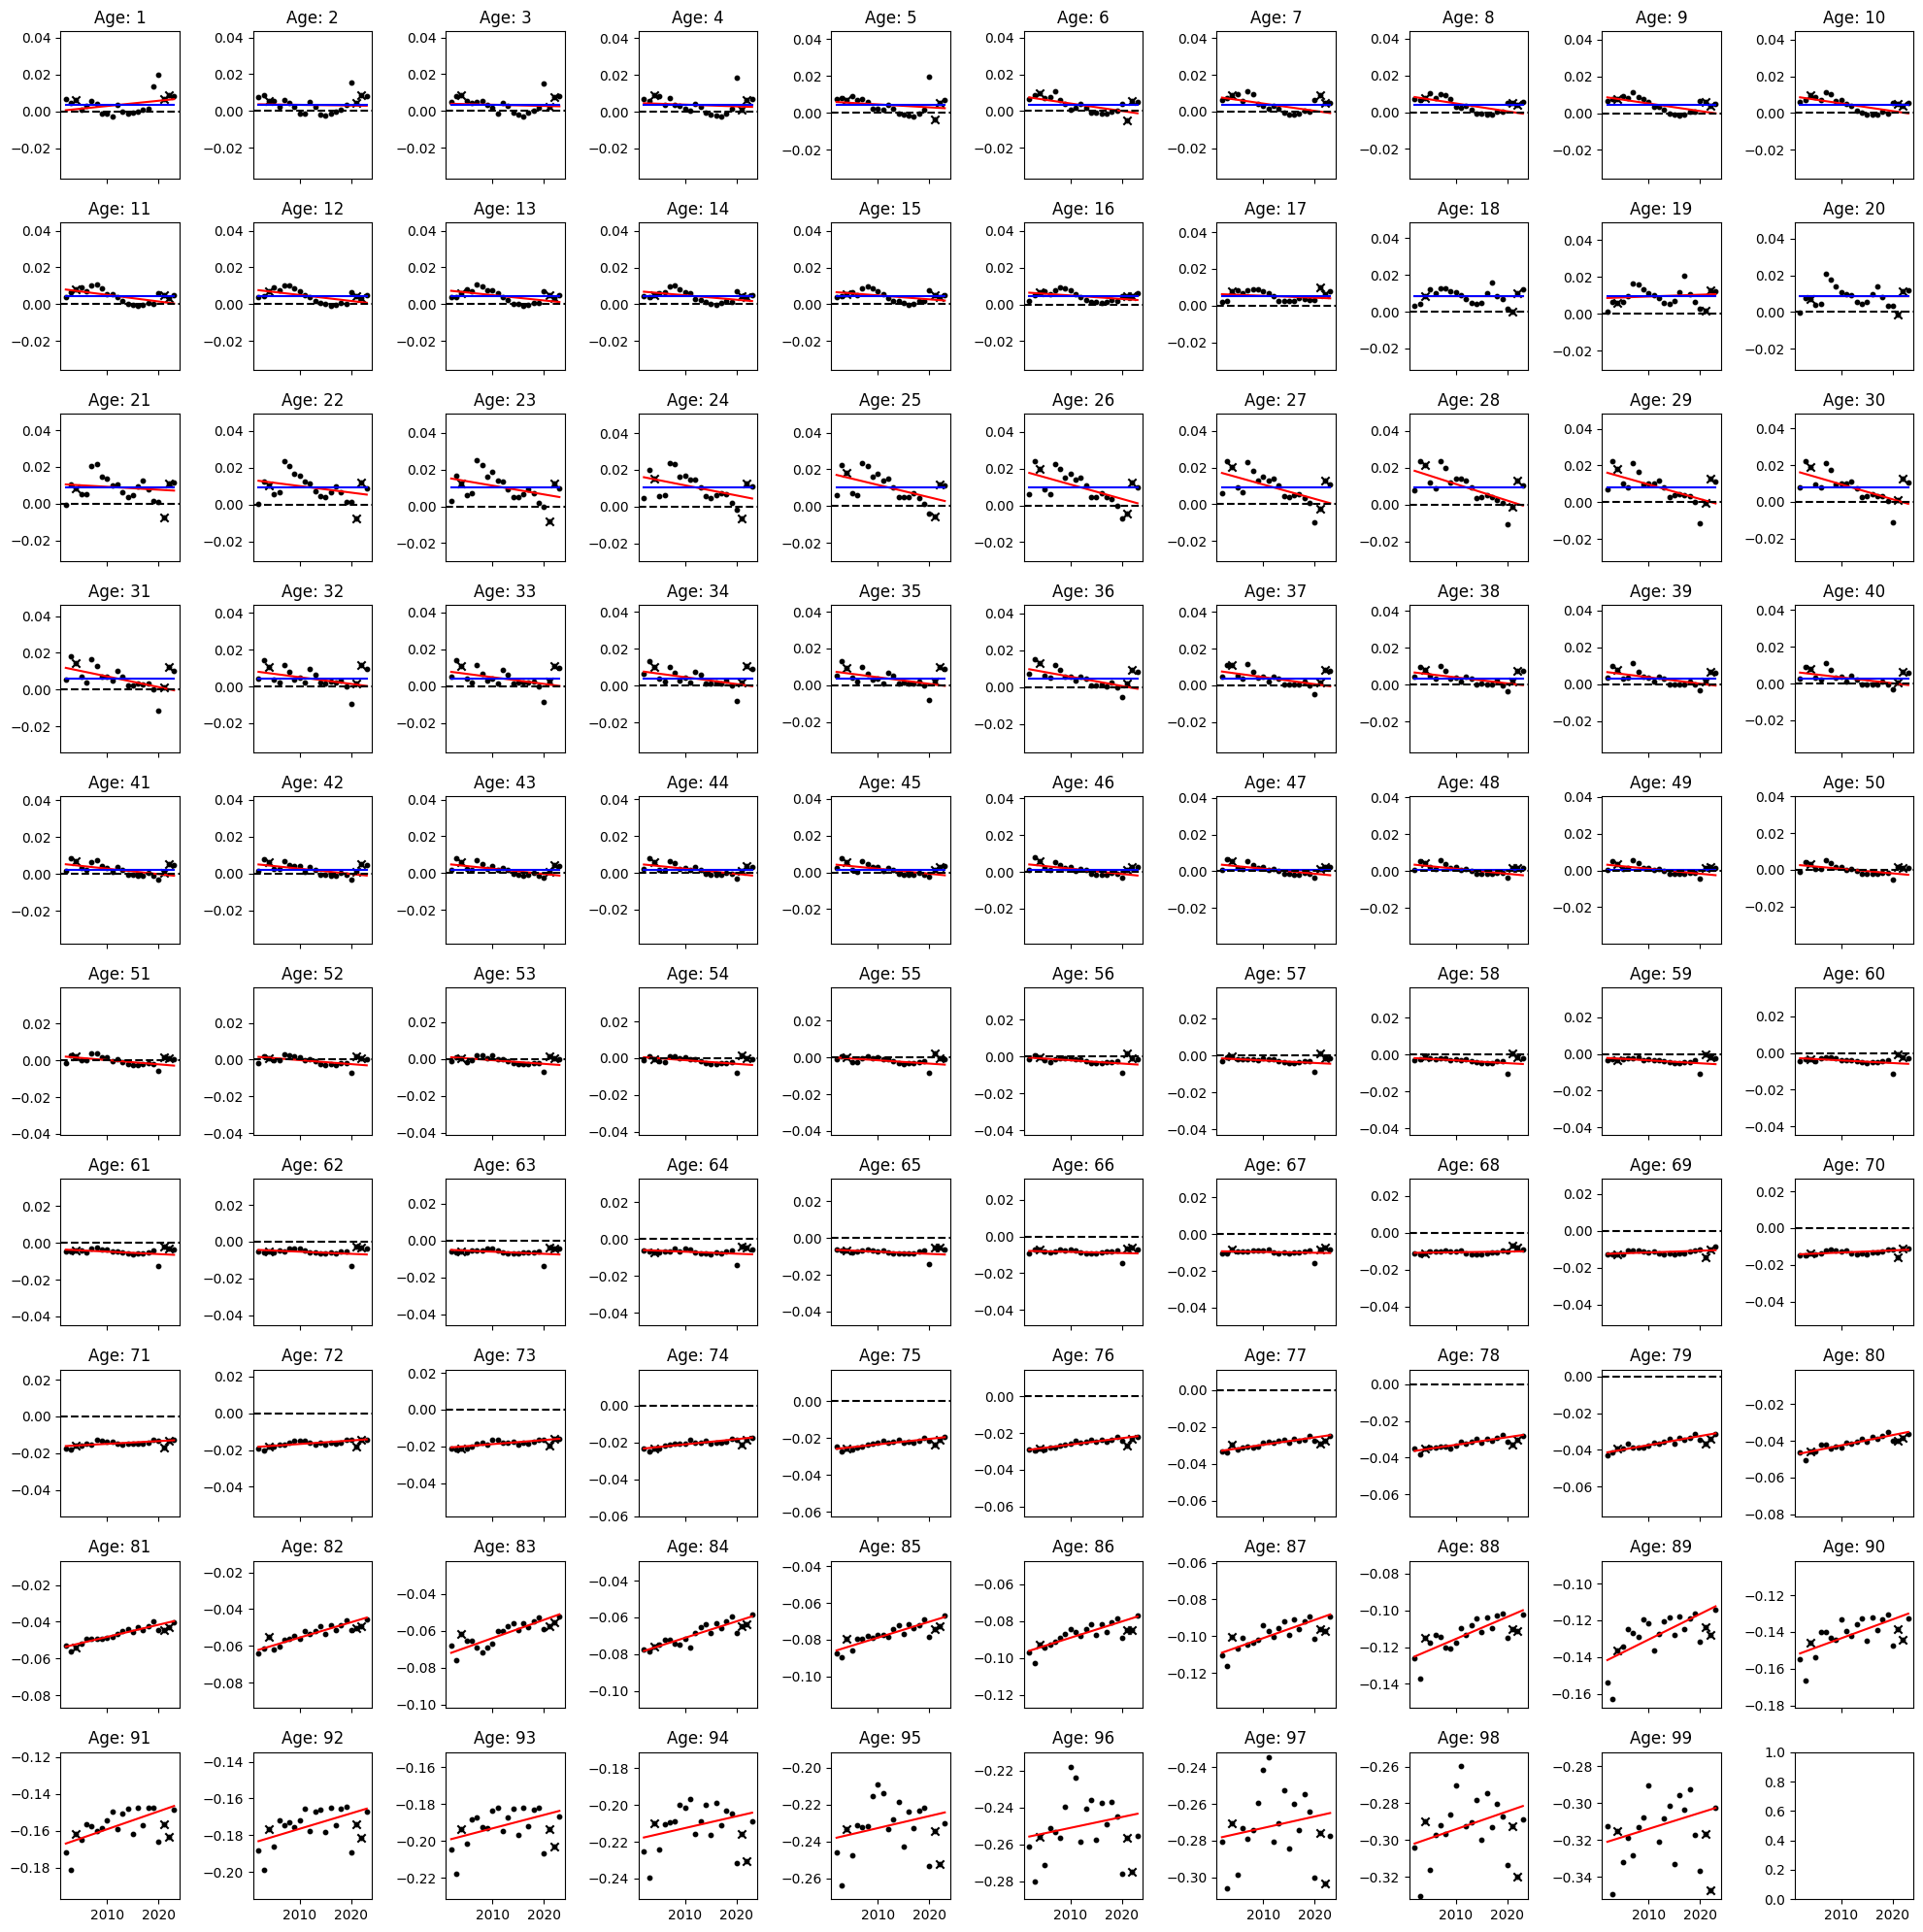

In [4]:
skip_years = [2004, 2021, 2022] # affected by heat wave and COVID - I will skip thit years from the fitting
valid_years = [yr for yr in dfpp.columns if yr not in skip_years]

dfsr = dfpp.drop(columns=skip_years).copy()
# fit a linear trend for every age group: linear regression of the pgr from 1 to 99 (lr_sr_1_99)
lr_sr_1_99 = dfsr.apply(lambda x: np.polyfit(x.index, x, 1), axis=1)
# Plot coefficients for every age group and the linear trend
fig, axs = plt.subplots(10,10, figsize=[20, 20], sharex=True)
for iplot, age in enumerate(dfsr.index):
    ax = axs.flatten()[iplot]
    ax.scatter(dfpp.columns, dfpp.loc[age].values, label=age, color="black", marker="o", s=10)
    ax.scatter(skip_years, dfpp[skip_years].loc[age], label=age, color="black", marker="x") # values not used for the fit (skip_years)
    ax.set_title(f"Age: {age}")
    ax.plot(dfsr.columns, np.polyval(lr_sr_1_99.loc[age], dfsr.columns), color="red") # linear fit
    if age<50: # average for the valid years
        ax.plot(dfsr.columns, [dfpp[valid_years].loc[age].mean()]*len(dfsr.columns), color="blue") # constant average
    ax.axhline(0, color="black", linestyle="--")
    y_avg = dfsr.loc[age].values.mean()
    y_margin = 0.04 # choose resonable values to fully show all the markers in the older ages
    ax.set_ylim(y_avg-y_margin, y_avg+y_margin) # note that I keep the same scale for all the plots, but transposed
plt.tight_layout()
print("Trend of population-growth-rate (pgr) by age group. Observations (black dots, X for the ones excluded from the fit), linear fit (red line), average (blue line).")
plt.show()

Results are quite rational:
- age < 50 (younger populat.): positive PGR due to a net balance between immigration - emigration. The trend is wavy.
- age >= 60 (older population): I see a clear negative SR, with a positive trend (i.e., less deadly) with the year, due to technology and care improvements

Therefore, I'm taking a pragmatic approach here, if I can not split the `pgr` into mortality and migration components.
- age < 50 - negligible mortality, the only variation is due to migration 
- 50<=age<60 - negligible migration, and as `pgr` I take some average rate
- age >= 60 - negligible migration, and as `pgr` are mainly due to mortality I will fit some model that consider the increasing trend of the survival rate due to care and technology improvements

In the next cell I will focus on the last, fitting the pgr for age >= 60: to do this I'm using an exponential decaying fit with asymptote at 0, so that the pgr can never get negative (care technology can not be so good to make old people resurrect!).

In [5]:
FIT_AGE_WINDOW = (60, 99)
years_projection = list(range(start_year, end_year+1))

fit_coeff22 = {}
fit_polyn22 = {}
for age in range(FIT_AGE_WINDOW[0],FIT_AGE_WINDOW[1]+1):
    fit_coeff22[age] = np.polyfit(dfpp.columns, np.log(-dfpp.loc[age]), 1)
    fit_polyn22[age]= np.poly1d(fit_coeff22[age])

fig = go.Figure()
colors = get_colors(FIT_AGE_WINDOW[1]-FIT_AGE_WINDOW[0]+1)
for i, age in enumerate(range(FIT_AGE_WINDOW[0],FIT_AGE_WINDOW[1]+1)):
    fig.add_trace(go.Scatter(x=dfpp.columns, y=dfpp.loc[age], mode='markers', marker=dict(color=colors[i]), name=str(age)))
    fig.add_trace(go.Scatter(x=years_projection, y=-np.exp(fit_polyn22[age](years_projection)), line=dict(color=colors[i]), name=str(age)))

fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Population Growth Rate ",
    showlegend=False,
    margin=dict(l=0, r=0, t=20, b=0),
    width=780,
    height=280,
)
fig.write_html("../images_plotly/3_pgr_extrapolation.html")
print("PGR by age (color) for >60 older people: historical data and decaying exponential fit")
fig.show()

df2100 = pd.DataFrame({age: -np.exp(fit_polyn22[age]([2100])) for age in range(FIT_AGE_WINDOW[0],FIT_AGE_WINDOW[1]+1)}, index=["PGR in 2100"]).T
fig = px.scatter(
    df2100,
    x=df2100.index,
    y="PGR in 2100",
    color=colors,
    color_discrete_sequence=colors,
    title="PGR by age (color): projection for 2100"
).update_layout(
    title=None,
    xaxis_title="Age",
    yaxis_title="Population Growth Rate",
    showlegend=False,
    margin=dict(l=0, r=15, t=20, b=0),
    width=780,
    height=280,
)

print("Projected PGR rate in 2100, by age (color & x-axis)")
fig.show()

PGR by age (color) for >60 older people: historical data and decaying exponential fit


Projected PGR rate in 2100, by age (color & x-axis)


This is a particular case because the group categorized as "100 or more" does not have any aging information.

In [6]:
df100 = dfp.loc[[99,100], range(start_year, 2020)].T
df100["sum"] = df100[99] + df100[100]
# make the survival rate the fraction of column "100" over the sum of columns "99" and "100" form the prvious year
df100["survival_rate"] = (df100[100] - df100["sum"].shift(1)) / df100["sum"].shift(1)
df100 = df100.drop(index=[start_year])

array([-1.31992076e-05, -3.33074749e-01])

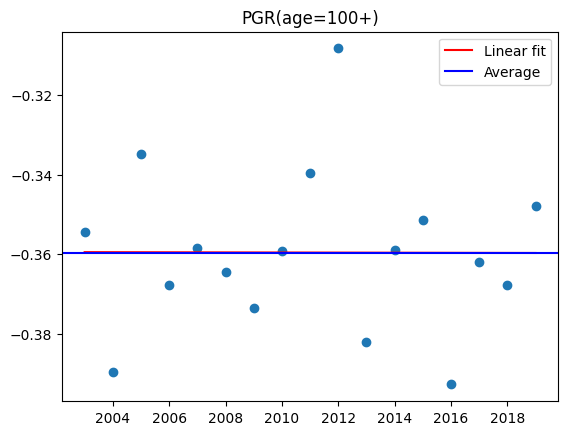

In [7]:
lr_pgr_100p = np.polyfit(df100.index, df100["survival_rate"], 1)
avg_pgr_100p = df100["survival_rate"].mean()
display(lr_pgr_100p)
# plot scatter and fit
plt.plot(df100.index, df100["survival_rate"], "o")
plt.plot(df100.index, np.polyval(lr_pgr_100p, df100.index), color="red", label="Linear fit")
plt.axhline(avg_pgr_100p, color="blue", label="Average")
plt.title("PGR(age=100+)")
plt.legend()
plt.show()

I can not spot any particular trend: therefore I will simply use an average value of the PGR of the 100+ group.

## Final prediction of future pgr (only due to mortality, migration excluded) 

Using the above considerations, I will predict the future pgr till 2100.

In [8]:
pgr_proj = pd.DataFrame(columns=range(last_year+1, end_year+1), index=range(1, 100))

for age in range(1,50):
    pgr_proj.loc[age] = 0

for age in range(50, 60):
    pgr_proj.loc[age] = dfpp.loc[age].mean() 
    
for age in range(60, 100):
    pgr_proj.loc[age] = -np.exp(fit_polyn22[age](pgr_proj.columns))
    
pgr_proj.loc[100] = avg_pgr_100p

# round to 4 decimal digits
sr_proj = pgr_proj.astype(float).round(3)

display(sr_proj)

,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,-0.249,-0.249,-0.249,-0.249,-0.249,-0.249,-0.248,-0.248,-0.248,-0.248,...,-0.240,-0.240,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239,-0.239
97,-0.272,-0.272,-0.272,-0.272,-0.272,-0.272,-0.272,-0.272,-0.272,-0.272,...,-0.268,-0.268,-0.268,-0.268,-0.268,-0.268,-0.268,-0.268,-0.268,-0.268
98,-0.288,-0.288,-0.288,-0.287,-0.287,-0.287,-0.286,-0.286,-0.285,-0.285,...,-0.265,-0.265,-0.265,-0.264,-0.264,-0.264,-0.263,-0.263,-0.263,-0.262
99,-0.310,-0.310,-0.310,-0.310,-0.309,-0.309,-0.309,-0.309,-0.308,-0.308,...,-0.295,-0.294,-0.294,-0.294,-0.294,-0.293,-0.293,-0.293,-0.293,-0.292


## Conclusions

- The best I could do with only information about the population balance, is to make VERY STRONG assumptions based on common sense
- Coming back on these data in 2025 I tried to browse better the ISTAT data, and I prefer not to use mortality data and migration data instead to predict the population growth rate in the future
- Therefore, this notebook just contains DEPRECATED calculations that will not be used for the final model